In [5]:
# Import necessary libraries
import torch
import os
from torch import nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision import datasets, models, transforms
from sklearn.metrics import f1_score




In [2]:
# Global parameters
USE_CUDA = torch.cuda.is_available()
# DATASET_PATH = 'E:/to24/20230409'
# DATASET_PATH = 'E:/to24/selective/all'
DATASET_PATH = 'E:/EuroSAT'
BATCH_SIZE = 64
NUM_EPOCHS = 20
LEARNING_RATE = 0.001
MOMENTUM = 0.9
WEIGHT_DECAY = 0.0005



In [3]:
# Data transformations
data_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

# Load datasets
train_dataset = datasets.ImageFolder(os.path.join(DATASET_PATH, 'train'), data_transforms)
train_loader = DataLoader(train_dataset, BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)

test_dataset = datasets.ImageFolder(os.path.join(DATASET_PATH, 'test'), data_transforms)
test_loader = DataLoader(test_dataset, BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)


class_names = train_dataset.classes
print('Dataloaders OK')


Dataloaders OK


C:\ProgramData\Anaconda3\envs\envGEOG0125\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\ProgramData\Anaconda3\envs\envGEOG0125\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)




Running epoch 1 of 20...

Epoch 1 Train Loss: 4.0500 Train Accuracy: 12.84%
Epoch 1 Test Loss: 1.9271 Test Accuracy: 23.26%
F1 Score=0.13888859391054437



Running epoch 2 of 20...

Epoch 2 Train Loss: 1.7563 Train Accuracy: 28.40%
Epoch 2 Test Loss: 1.6642 Test Accuracy: 28.93%
F1 Score=0.18133024756971244



Running epoch 3 of 20...

Epoch 3 Train Loss: 1.5620 Train Accuracy: 35.95%
Epoch 3 Test Loss: 1.4546 Test Accuracy: 45.61%
F1 Score=0.3978030902320072



Running epoch 4 of 20...

Epoch 4 Train Loss: 1.3586 Train Accuracy: 47.10%
Epoch 4 Test Loss: 1.3447 Test Accuracy: 47.78%
F1 Score=0.40673025232605486



Running epoch 5 of 20...

Epoch 5 Train Loss: 1.1756 Train Accuracy: 55.02%
Epoch 5 Test Loss: 1.0886 Test Accuracy: 59.44%
F1 Score=0.5564575643882212



Running epoch 6 of 20...

Epoch 6 Train Loss: 1.0296 Train Accuracy: 61.50%
Epoch 6 Test Loss: 1.0590 Test Accuracy: 62.20%
F1 Score=0.5974981718380433



Running epoch 7 of 20...

Epoch 7 Train Loss: 0.9214 Train Accura

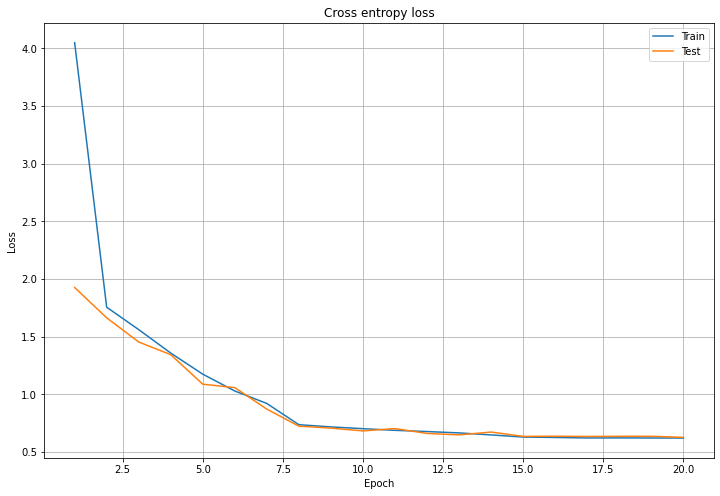

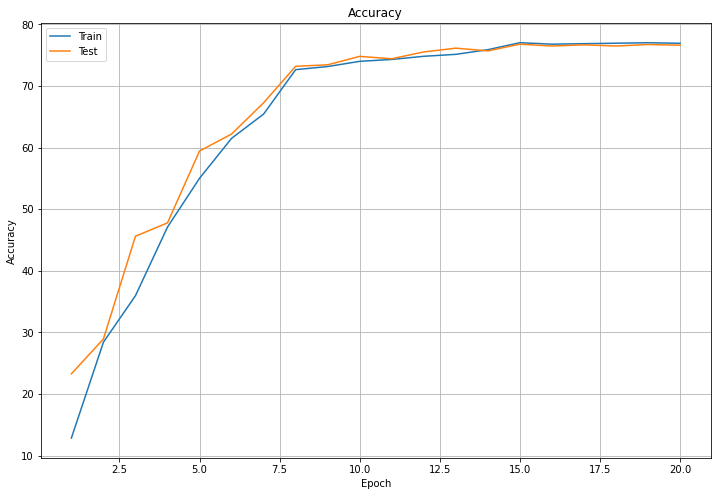

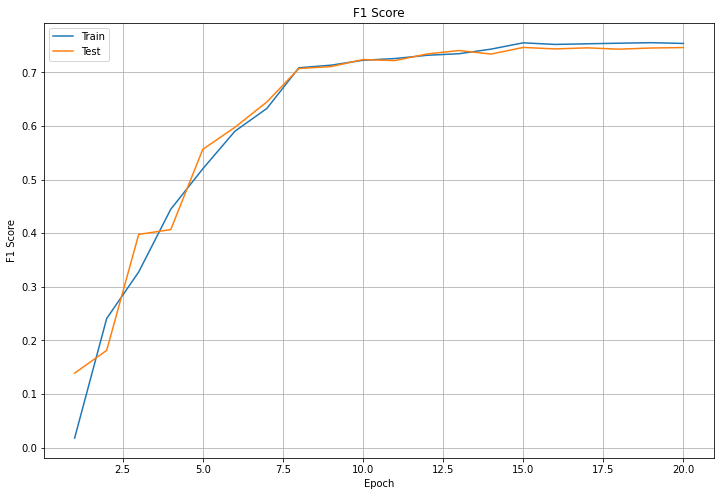

In [6]:
# Using VGG16 with pretrained weights
model = models.alexnet(pretrained=False)
# model.classifier[6] = nn.Linear(4096, len(train_dataset.classes))

if USE_CUDA:
    model = model.cuda()

# Define criterion, optimizer, and scheduler
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

train_loss = []
train_accuracy = []
train_f1_scores = []
test_loss = []
test_accuracy = []
test_f1_scores = []
epochs = []

for epoch in range(1, NUM_EPOCHS+1):
    print(f'\n\nRunning epoch {epoch} of {NUM_EPOCHS}...\n')
    epochs.append(epoch)
    # Training
    model.train()
    correct = 0
    iterations = 0
    iter_loss = 0.0
    train_preds = []
    train_targets = []
    for i, (inputs, labels) in enumerate(train_loader):
        if USE_CUDA:
            inputs = inputs.cuda()
            labels = labels.cuda()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        iter_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        iterations += 1

        train_preds.extend(predicted.cpu().numpy())
        train_targets.extend(labels.cpu().numpy())
        
    scheduler.step()
    train_loss.append(iter_loss/iterations)
    train_accuracy.append((100 * correct / len(train_dataset)))
    train_f1 = f1_score(train_targets, train_preds, average='macro')
    train_f1_scores.append(train_f1)

    # Testing
    model.eval()
    correct = 0
    iterations = 0
    testing_loss = 0.0
    test_preds = []
    test_targets = []
    for i, (inputs, labels) in enumerate(test_loader):
        if USE_CUDA:
            inputs = inputs.cuda()
            labels = labels.cuda()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        testing_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        iterations += 1

        test_preds.extend(predicted.cpu().numpy())
        test_targets.extend(labels.cpu().numpy())
        
    test_loss.append(testing_loss/iterations)
    test_accuracy.append((100 * correct / len(test_dataset)))
    test_f1 = f1_score(test_targets, test_preds, average='macro')
    test_f1_scores.append(test_f1)
    
    print(f'Epoch {epoch} Train Loss: {train_loss[-1]:.4f} Train Accuracy: {train_accuracy[-1]:.2f}%')
    print(f'Epoch {epoch} Test Loss: {test_loss[-1]:.4f} Test Accuracy: {test_accuracy[-1]:.2f}%')

    print(f'F1 Score={test_f1}\n')

    # Plot and save
    plt.figure(figsize=(12, 8), num=1)
    plt.clf()
    plt.plot(epochs, train_loss, label='Train')
    plt.plot(epochs, test_loss, label='Test')
    plt.legend()
    plt.grid()
    plt.title('Cross entropy loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.figure(figsize=(12, 8), num=2)
    plt.clf()
    plt.plot(epochs, train_accuracy, label='Train')
    plt.plot(epochs, test_accuracy, label='Test')
    plt.legend()
    plt.grid()
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')

    plt.figure(figsize=(12, 8), num=3)
    plt.clf()
    plt.plot(epochs, train_f1_scores, label='Train')
    plt.plot(epochs, test_f1_scores, label='Test')
    plt.legend()
    plt.grid()
    plt.title('F1 Score')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')